# Training Notebook

we first need to build torchvision from source as it allows us to use ffmpeg and video_reader backend

In [ ]:
# import distutils
# distutils.spawn.find_executable('ffmpeg')

In [ ]:
# !apt install libavformat-dev libavcodec-dev libavdevice-dev libavutil-dev libswscale-dev libavresample-dev libavfilter-dev -y
# !pip uninstall torchvision -y
# !rm -r vision/
# !git clone https://github.com/pytorch/vision.git
# %cd vision
# !python setup.py install
# %cd /kaggle/working
!pip install pytorchvideo av torchvision --upgrade

# Restart but not reset because of av installation

In [ ]:
!pip show torchvision

In [1]:
import torchvision
import torch
from torch import nn, Tensor
from torchvision import models
import math
import gc
import random


random.seed(0)
torch.manual_seed(0)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
torch.cuda.empty_cache()
# torchvision.set_video_backend('video_reader')

## Modelling Pipeline

In [2]:
from torchvision.models.vision_transformer import Encoder

class PatchEmbedding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 15):
        super(PatchEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model), requires_grad=True)
        
        frames = max_len + 1
        position = torch.arange(frames).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, frames, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
        # self.pe = nn.Parameter(torch.randn((1, frames, d_model)))
        # self.temp = nn.Parameter(torch.randn(1,max_len,d_model), requires_grad=True)


    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, n_frames, embedding_dim]
        """
        
        b, _, _ = x.shape
        
        # temp = self.temp.expand(b, -1, -1)
        # x = x * temp
        
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        x = x + self.pe # [:, :x.size(1), :]
        return self.dropout(x)

class FeatureExtractor(nn.Module):
    def __init__(self, d_model: int, model_name: str, model_weights: str = 'DEFAULT'):
        super(FeatureExtractor, self).__init__()
        # assert model_name in ['efficientnet_v2_s', 'efficientnet_v2_m', 'efficientnet_v2_l', 'resnet18', 'resnet50', 'inception_v3', 'wide_resnet50_2', 'wide_resnet101_2']
        if model_weights is None:
            pretrain=False
        else:
            pretrain=True
        self.model = getattr(models, model_name)(pretrained=pretrain)
        
        if model_name in ['efficientnet_v2_s', 'efficientnet_v2_m', 'efficientnet_v2_l']:
            self.model.classifier = nn.Linear(in_features=self.model.classifier[1].in_features, out_features = d_model)
        else:
            self.model.fc = nn.Linear(in_features=self.model.fc.in_features ,out_features=d_model)
            
        

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, n_frames, channels, height, width]
        """
        b, f, _, _, _ = x.shape
        x = x.view(b*f, *x.size()[2:])
        x = self.model(x)
        x = x.view(b, f, *x.size()[1:])
        
        return x


class ConvAcTransformer(nn.Module):
    def __init__(self, d_model: int,
                 attention_heads: int,
                 num_layers: int,
                 num_classes: int,
                 num_frames: int,
                 feature_extractor_name: str):
        super(ConvAcTransformer, self).__init__()
        self.d_model = d_model
        self.feature_extractor_name = feature_extractor_name
        self.attention_heads = attention_heads
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.num_frames = num_frames

        
        self.feature_extract = FeatureExtractor(self.d_model, self.feature_extractor_name, model_weights='DEFAULT')
        self.patch_embed = PatchEmbedding(self.d_model)
        
        self.transformer_encoder = Encoder(seq_length=self.num_frames+1,
                                           num_layers=self.num_layers,
                                           num_heads=self.attention_heads,
                                           hidden_dim=self.d_model, 
                                           mlp_dim=self.d_model,
                                           dropout=0.1, attention_dropout=0.1)

        self.classification_head = nn.Linear(self.d_model, self.num_classes)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, n_frames, channels, height, width]
        """
        # extract features from all frames
        x = self.feature_extract(x)

        # apply patch embedding from ViT
        x = self.patch_embed(x)

        # ViT encoder
        x = self.transformer_encoder(x)

        # select first token/classifier token
        x = x[:, 0, :]

        # classification head
        x = self.classification_head(x)

        return x


# test
test_tensor = torch.randn(2, 15, 3, 128, 128, dtype=torch.float32).to(DEVICE)
model = ConvAcTransformer(d_model=256, attention_heads=4, num_frames=15, num_layers=4, num_classes=10, feature_extractor_name='resnet18')
model = model.to(device=DEVICE)
out = model(test_tensor)
print(out.size())
diff = out.mean().backward()
print("done")
del test_tensor,out, diff
gc.collect()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([2, 10])
done


9

In [3]:
# list(model.feature_extract.named_parameters())[0][1].grad#.size() #[0,14]

In [4]:
# a = torch.randn(16,15,3,128,128)
# a[:, 0].size()

## Data Pipeline

#### Data download using next cell: (comment if it's already there)

UCF-101 Download:

In [ ]:
# !apt install unrar 
# !wget https://www.crcv.ucf.edu/data/UCF101/UCF101.rar --no-check-certificate
# !wget https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip --no-check-certificate
# !unrar  x UCF101.rar -idq
# !unzip UCF101TrainTestSplits-RecognitionTask.zip
# ! rm UCF101.rar UCF101TrainTestSplits-RecognitionTask.zip

UCF-50 Download:

In [ ]:
!apt install unrar 
!wget https://www.crcv.ucf.edu/data/UCF50.rar --no-check-certificate
!unrar x UCF50.rar -idq
!mkdir ./ucf50TrainTestlist
!wget -P ./ucf50TrainTestlist https://github.com/temur-kh/video-classification-cv/raw/master/data/classInd.txt
!wget -O ./ucf50TrainTestlist/testlist01.txt https://github.com/temur-kh/video-classification-cv/raw/master/data/testlist.txt
!wget -O ./ucf50TrainTestlist/trainlist01.txt https://github.com/temur-kh/video-classification-cv/raw/master/data/trainlist.txt
! rm UCF50.rar 

In [ ]:
class_ind = ["BaseballPitch", "Basketball", "BenchPress", "Biking", "Billiards", "BreastStroke", "CleanAndJerk", "Diving", "Drumming", "Fencing"]
files = ["testlist01.txt", "trainlist01.txt", "classInd.txt"]
for file in files:
    with open(f"./ucf50TrainTestlist/{file}", "r+") as f:
        d = f.readlines()
        f.seek(0)
        for i in d:
            if any(substring in i for substring in class_ind):
                f.write(i)
        f.truncate()


In [ ]:
import os, shutil
os.listdir('./UCF50')
for i in os.listdir("./UCF50"):
    if i not in class_ind:
        shutil.rmtree(f'./UCF50/{i}')
        


In [5]:
from torchvision.datasets import UCF101
from torchvision import transforms

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
# from pytorchvideo.transforms import (
#     ApplyTransformToKey,
#     ShortSideScale,
#     UniformTemporalSubsample
# )
side_size = 128
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
crop_size = 128
num_frames = 8
sampling_rate = 8
frame_to_skip = 3


transforms = transforms.Compose([
    # transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    transforms.Lambda(lambda x: x[::2]), # skip second frame
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    # transforms.CenterCrop(60),
    # transforms.RandomRotation(degrees=10, interpolation=transforms.InterpolationMode.BILINEAR),
    # transforms.GrayScale(),
    # transforms.GaussianBlur(kernel_size=3),
    # transforms.ColorJitter(brightness=.2, hue=.1),
    # transforms.RandomPerspective(distortion_scale=0.1),
    # transforms.AugMix(),
    # transforms.RandAugment(),
    Lambda(lambda x: x.permute(3, 0, 1, 2)), # THWC -> CTHW
    Lambda(lambda x: x/255.0),
    #NormalizeVideo(mean, std),
    #ShortSideScale(size=side_size),
    # CenterCropVideo(crop_size=(crop_size, crop_size)),
    Lambda(lambda x: x.permute(1, 0, 2, 3)), # CTHW -> TCHW
    transforms.Resize((side_size, side_size)),

    # transforms.Lambda(lambda x: x / 255.),
    transforms.Lambda(lambda x: x.float()),
])

train_dataset = UCF101(root = './UCF50/', annotation_path = './ucf50TrainTestlist/', transform=transforms, train=True, frames_per_clip=30, step_between_clips=2) # ,_video_width=128, _video_height=128)
# valtest_dataset = UCF101(root = './UCF-101/', annotation_path = './ucfTrainTestlist/', transform=transforms ,_video_width=128, _video_height=128, train=False, frames_per_clip=30)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/_functional_video.py:7: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms.functional' module instead.
  "The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. "
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms' module instead.
  "The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in 0.14. "


  0%|          | 0/87 [00:00<?, ?it/s]

In [6]:
train_dataset[0][0].size()

/opt/conda/lib/python3.7/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([15, 3, 128, 128])

In [7]:
# del model, x, y, loss
# gc.collect()
len(train_dataset.classes)

10

In [8]:

indices = random.sample(list(range(len(train_dataset))), 500)

# Warp into Subsets
train_subset = torch.utils.data.Subset(train_dataset, indices[:-200])
test_subset = torch.utils.data.Subset(train_dataset, indices[-100:])
val_subset = torch.utils.data.Subset(train_dataset, indices[-200:-100])

In [9]:
def custom_collate(batch):
    # skip audio data
    filtered_batch = []
    for video, _, label in batch:
        filtered_batch.append((video, label))
    return torch.utils.data.dataloader.default_collate(filtered_batch)

BATCH_SIZE = 16
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=2, pin_memory=True,
                                           collate_fn=custom_collate)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=2, pin_memory=True,
                                           collate_fn=custom_collate)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=2,
                                           collate_fn=custom_collate)

print(f"Total number of train samples: {len(train_subset)}")
print(f"Total number of test samples: {len(test_subset)}")
print(f"Total number of val samples: {len(val_subset)}")
print(f"Total number of (train) batches: {len(train_loader)}")
print(f"Total number of (test) batches: {len(test_loader)}")
print(f"Total number of (val) batches: {len(val_loader)}")

Total number of train samples: 300
Total number of test samples: 100
Total number of val samples: 100
Total number of (train) batches: 19
Total number of (test) batches: 7
Total number of (val) batches: 7


### Visualization

In [10]:
# !pip install imageio-ffmpeg
import imageio
from IPython.display import Video
import numpy as np

for i, (fm,lb) in enumerate(train_loader):
    print("Dataset batch shape", fm.size(), fm.dtype, lb,  lb.dtype )
    # break
    video = fm[0].permute(0, 2, 3, 1).numpy() 
    # print(video.min(), video.max(), video.mean(), video.std())
    video = (video * 255.0).astype(np.uint8)
    label = train_dataset.classes[lb[0]]
    
    print("Example:", label)
    imageio.mimwrite('./test.mp4', video, fps=30)
    break

Video('./test.mp4', width=256, height=256, embed=True)

Dataset batch shape torch.Size([16, 15, 3, 128, 128]) torch.float32 tensor([3, 5, 2, 3, 8, 4, 3, 0, 0, 7, 3, 5, 4, 4, 9, 8]) torch.int64
Example: Biking


## Training Pipeline

In [11]:
torch.cuda.empty_cache()
!nvidia-smi

Tue Jul 12 20:05:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |    981MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython import display
import time
%matplotlib inline

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
#         print(n)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
#             print(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu())
            max_grads.append(p.grad.abs().max().detach().cpu())
            
#         if len(max_grads)> 10:
#             break
    max_grads = max_grads[-60:]
    ave_grads = ave_grads[-60:]
    layers = layers[-60:]
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [13]:
# list(model.named_parameters())

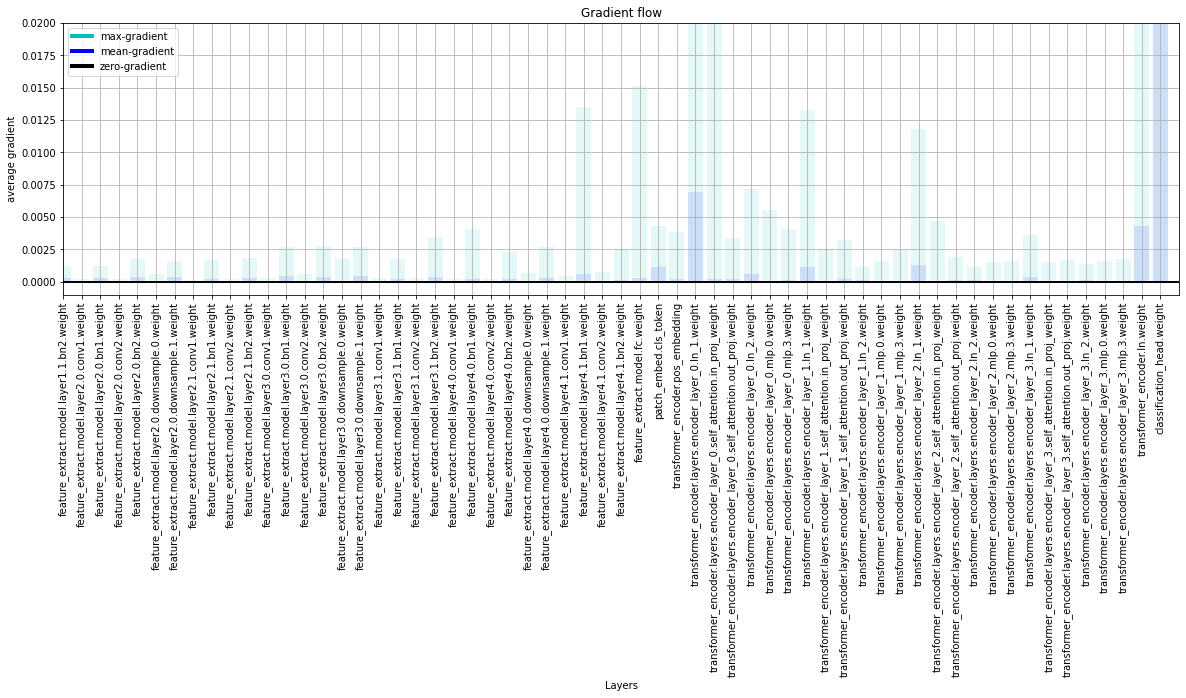

Epoch 5/200 train loss: 2.08, train acc 29.67


Total Training Done::   2%|▎         | 5/200 [01:37<1:03:14, 19.46s/it]

Epoch 5/200 val loss: 2.11 Val accuracy: 23.00%


Epoch 6:  32%|███▏      | 6/19 [00:04<00:07,  1.76it/s]

In [ ]:
from torch import optim
from tqdm import tqdm
import copy

# Defining model and training options
model = model.to(device=DEVICE)

N_EPOCHS = 200
LR = 0.01
MODEL_PATH = 'best_model_ucf50_x128_sub_30'
best_val_acc = 0
best_model = None
pretrain = False

# Training loop
optimizer = optim.Adam(model.parameters(), lr=LR) #, weight_decay=0.1)
criterion = nn.CrossEntropyLoss(reduction='mean')
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [80, 140, 180], gamma=0.75, verbose=True)

if pretrain:
    checkpoint = torch.load(f"./{MODEL_PATH}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for epoch in tqdm(range(N_EPOCHS), desc="Total Training Done:", leave=False):
        # TRAINING
        train_loss = 0.0
        count = 0
        model.train()
        t_loader = iter(train_loader)
        t_correct, t_total = 0, 0
        # plt.figure()
        for batch in tqdm(range(len(train_loader)), desc=f"Epoch {epoch + 1}", position=0):
            x, y = next(t_loader)
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_hat = model(x)
            loss = criterion(y_hat, y) #/ len(x)

            train_loss += loss.detach().cpu().item()
            #print(loss.detach().cpu().item())
            optimizer.zero_grad()
            loss.backward()  
            optimizer.step()
            
            t_correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            t_total += len(x)
            
            count+=1

            #if count>3000:
            #    break
        train_acc = t_correct / t_total * 100
        
        scheduler.step()
        
        display.clear_output(wait=True)
        plt.clf()
        plt.figure(figsize=(20, 5))
        plot_grad_flow(model.named_parameters())
        display.display(plt.gcf())
        time.sleep(1)
        
        print(f"Epoch {epoch + 1}/{N_EPOCHS} train loss: {train_loss/count:.2f}, train acc {train_acc:.2f}")
        # TODO: LR DECAY
        
        # VALIDATION
        val_loss = 0.0
        v_correct, v_total = 0, 0
        vcount = 0
        model.eval()
        with torch.no_grad():
            v_loader = iter(val_loader)
            for batch in tqdm(range(len(val_loader)), desc="Validating", position=0):
                x, y = next(v_loader)
                x, y = x.to(DEVICE), y.to(DEVICE)
                y_hat = model(x)
                loss = criterion(y_hat, y) #/ len(x)
                val_loss += loss.detach().cpu().item()

                v_correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
                v_total += len(x)
                
                vcount+=1
            
            val_acc = v_correct / v_total * 100
            if(best_val_acc < val_acc):
                best_model = copy.deepcopy(model)
                
                best_val_acc = val_acc
                print(f"Best accuracy: {best_val_acc}")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, f"./{MODEL_PATH}.pt")
                
                best_model = best_model.cpu()
                torch.cuda.empty_cache()
        
        print(f"Epoch {epoch + 1}/{N_EPOCHS} val loss: {val_loss/vcount:.2f} Val accuracy: {val_acc:.2f}%")
        



In [ ]:
best_val_acc

In [ ]:
del best_model, model, x, y, y_hat, loss, v_correct
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
# val_acc, val_loss, train_loss

In [ ]:
# import gc
# # del model
# del best_model
# gc.collect()


In [ ]:
# Test loop on latest model
# torch.cuda.empty_cache()
correct, total = 0, 0
test_loss = 0.0
model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", position=0, leave=True):
        x, y = batch
        x, y = x.to(DEVICE), y.to(DEVICE)
        y_hat = model(x)
        loss = criterion(y_hat, y) # / len(x)
        test_loss += loss.detach().cpu().item()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)

        if total > 1000:
            break
    
print("Latest Model")
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {correct / total * 100:.2f}%")

In [ ]:
# Test loop on best model
# torch.cuda.empty_cache()
# test_model = ConvAcTransformer(d_model=512, attention_heads=4, num_layers=4, num_classes=101, feature_extractor_name='efficientnet_v2_s')
# test_model = test_model.to(device=DEVICE)
# MODEL_PATH = 'best_model_ucf101_x128'

# criterion = nn.CrossEntropyLoss()
# checkpoint = torch.load(f"./{MODEL_PATH}.pt")
# test_model.load_state_dict(checkpoint['model_state_dict'])

correct, total = 0, 0
test_loss = 0.0
best_model.eval()
for batch in tqdm(test_loader, desc="Testing", position=0, leave=True):
    x, y = batch
    x, y = x.to(DEVICE), y.to(DEVICE)
    y_hat = best_model(x)
    loss = criterion(y_hat, y) # / len(x)
    test_loss += loss.detach().cpu().item()

    correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
    total += len(x)

    if total > 17:
        break
    
print("Best Model")
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {correct / total * 100:.2f}%")